In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.feature_selection import RFE

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

from imblearn.under_sampling import RandomUnderSampler

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

from scipy.stats import randint
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

In [4]:
train = pd.read_csv('train.csv')
train_label = train['target']

X_train, X_test, y_train, y_test = train_test_split(train, train_label, test_size=0.2)

In [12]:
X_train = X_train.drop(['id', 'target'], axis=1)
X_test = X_test.drop(['id', 'target'], axis=1)

In [13]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [16]:
lasso = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
xgb = XGBClassifier()

voter = VotingClassifier(estimators=[('lasso', lasso), ('xgb', xgb)], voting='soft')
voter.fit(X_train, y_train)

VotingClassifier(estimators=[('lasso', LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)), (...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "g--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "y-", label="Recall", linewidth=2)
    # The last precision and recall values are 1 and 0 respectively
    # and do not have a corresponding threshold. This ensures that the graph starts on the y axis
    
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16, color = 'yellow')
    plt.ylabel("Precision", fontsize=16, color = 'green')
    plt.axis([0, 1, 0, 1])
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16, color = "darkgoldenrod")
    plt.ylabel('TPR (Recall)', fontsize=16, color = "yellow")

---------- LogisticRegression precision vs recall ----------


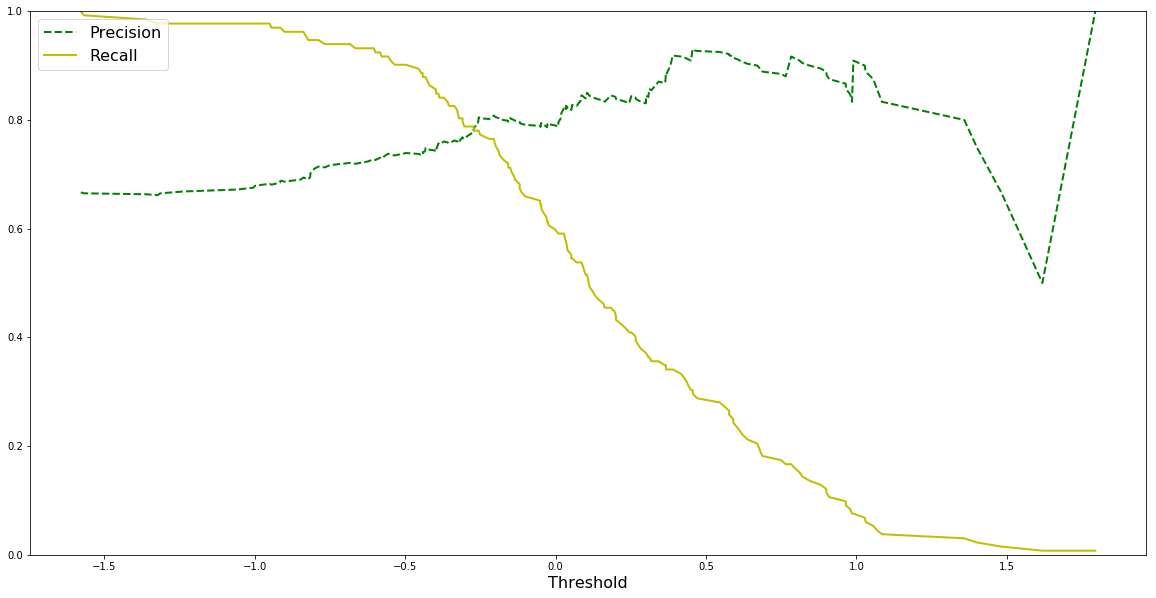

---------- LogisticRegression PR curve ----------


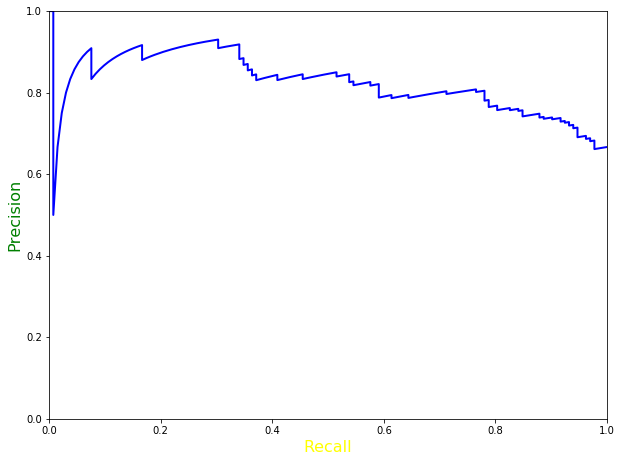

---------- LogisticRegression ROC curve ----------


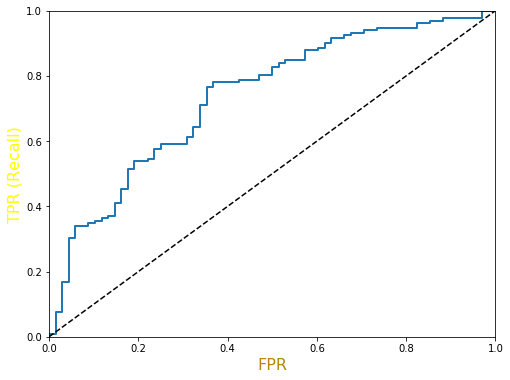

LogisticRegression
[[19  3]
 [ 7 21]]
 accuracy: 0.8
precision: 0.875
recall: 0.75
Under PR curve: 0.8254604914634982
roc_auc: 0.8068181818181819
0.7368538324420678

---------- XGBClassifier precision vs recall ----------


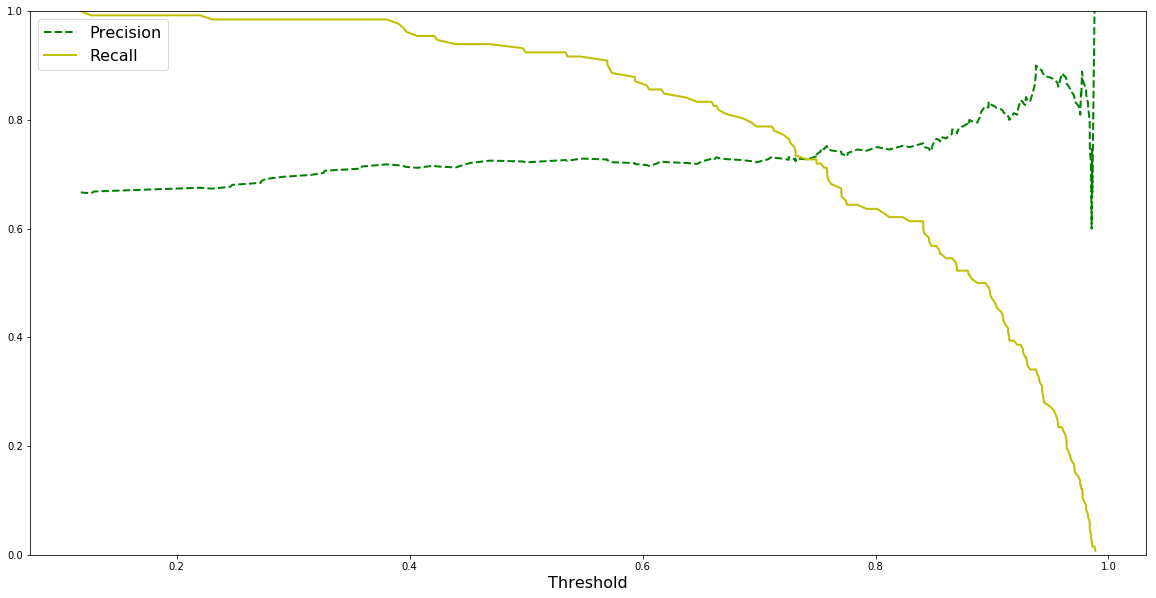

---------- XGBClassifier PR curve ----------


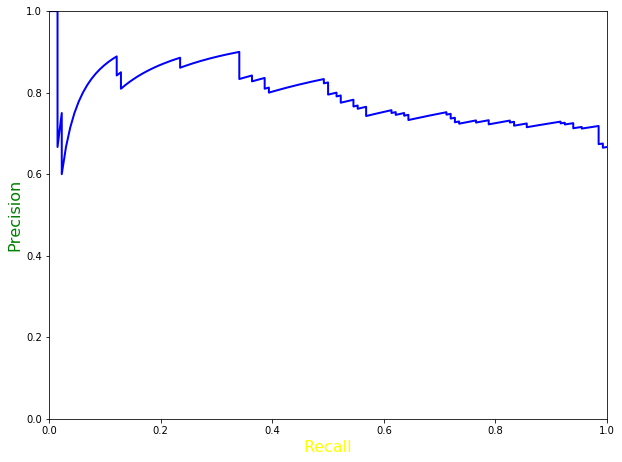

---------- XGBClassifier ROC curve ----------


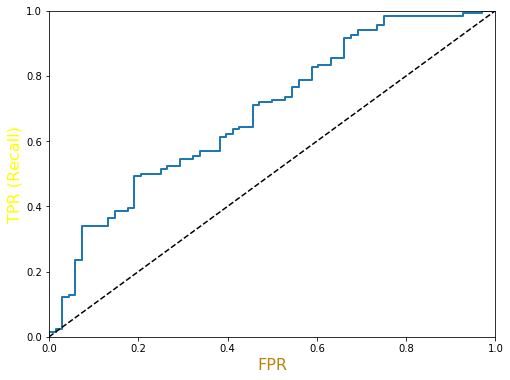

XGBClassifier
[[10 12]
 [ 3 25]]
 accuracy: 0.7
precision: 0.6756756756756757
recall: 0.8928571428571429
Under PR curve: 0.7918617206874223
roc_auc: 0.6737012987012987
0.6878342245989305

---------- VotingClassifier precision vs recall ----------


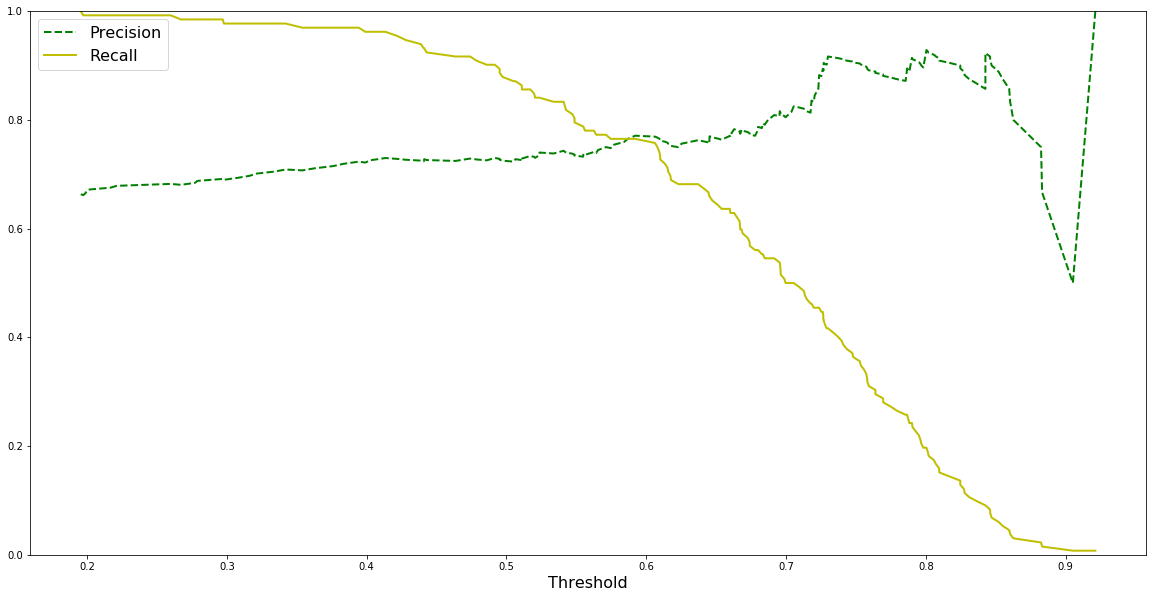

---------- VotingClassifier PR curve ----------


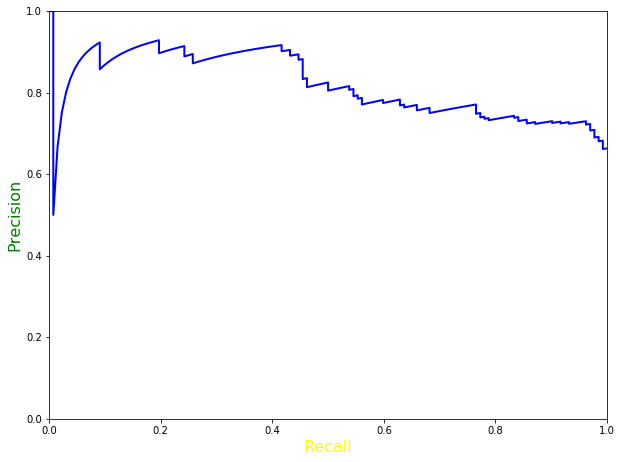

---------- VotingClassifier ROC curve ----------


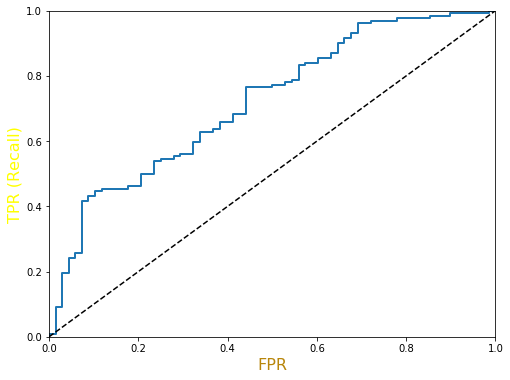

VotingClassifier
[[11 11]
 [ 3 25]]
 accuracy: 0.72
precision: 0.6944444444444444
recall: 0.8928571428571429
Under PR curve: 0.8196613459665322
roc_auc: 0.6964285714285714
0.7195855614973262



In [36]:
for clf in (lasso, xgb, voter):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    if hasattr(clf, 'decision_function') :
        y_scores = cross_val_predict(clf, X_train, y_train, cv=3, method='decision_function')
    else:
        y_scores = cross_val_predict(clf, X_train, y_train, cv=3, method='predict_proba')[:,1]
    
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    
    print("----------", clf.__class__.__name__, "precision vs recall ----------")
    plt.figure(figsize=(20,10))
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    plt.show()
    
    print("----------", clf.__class__.__name__, "PR curve ----------")
    plt.figure(figsize=(10, 7.5))
    plot_precision_vs_recall(precisions, recalls)
    plt.show()
    under_curve = average_precision_score(y_train, y_scores)
    
    
    print("----------", clf.__class__.__name__, "ROC curve ----------")
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    plt.show()
    

    print(clf.__class__.__name__) 
    print(confusion_matrix(y_test, y_pred))
    print(' accuracy:',accuracy_score(y_test, y_pred))
    print('precision:', precision_score(y_test, y_pred))
    print('recall:', recall_score(y_test, y_pred))
    print('Under PR curve:',under_curve)
    print('roc_auc:', roc_auc_score(y_test, y_pred))
    print(roc_auc_score(y_train, y_scores))
    print()

In [41]:
coef = lasso.coef_[0]
new_features=[]
for i in range(len(coef)):
    print(i, 'feature', coef[i])
    if coef[i] != 0:
        new_features.append(i)
print(new_features)

0 feature 0.0
1 feature 0.0
2 feature 0.0
3 feature 0.0
4 feature 0.0
5 feature 0.0
6 feature 0.0
7 feature 0.0
8 feature 0.0
9 feature -0.030833832460808338
10 feature 0.0
11 feature 0.0
12 feature 0.0
13 feature 0.0
14 feature 0.0
15 feature 0.0
16 feature -0.05423658432452177
17 feature 0.0
18 feature 0.02873463443061621
19 feature 0.0
20 feature 0.0
21 feature 0.0
22 feature 0.0
23 feature 0.0
24 feature 0.0
25 feature 0.0
26 feature 0.0
27 feature 0.0
28 feature 0.0
29 feature 0.0
30 feature 0.13915952001025272
31 feature 0.0
32 feature 0.0
33 feature 0.6318289252032593
34 feature 0.0
35 feature 0.0
36 feature 0.0
37 feature 0.0
38 feature 0.0
39 feature -0.04899722934517571
40 feature 0.0
41 feature 0.0
42 feature 0.0
43 feature -0.10516230525911713
44 feature 0.0
45 feature 0.0
46 feature 0.0
47 feature 0.0
48 feature 0.0
49 feature 0.0
50 feature 0.0
51 feature 0.0
52 feature 0.0
53 feature 0.0
54 feature 0.0
55 feature 0.0
56 feature 0.0
57 feature 0.0
58 feature -0.0360547291

In [43]:
fi = xgb.feature_importances_
importances=[]
for i in range(len(fi)):
    print(i, 'feature', fi[i])
    if fi[i] != 0:
        tmp = (i, fi[i])
        importances.append(tmp)
print(importances)

0 feature 0.0053475937
1 feature 0.0035650623
2 feature 0.0
3 feature 0.0
4 feature 0.0035650623
5 feature 0.0
6 feature 0.0
7 feature 0.0017825312
8 feature 0.0
9 feature 0.037433155
10 feature 0.0
11 feature 0.0017825312
12 feature 0.010695187
13 feature 0.0
14 feature 0.0
15 feature 0.0035650623
16 feature 0.0071301246
17 feature 0.0053475937
18 feature 0.0089126555
19 feature 0.0
20 feature 0.0071301246
21 feature 0.0071301246
22 feature 0.0
23 feature 0.0
24 feature 0.0071301246
25 feature 0.0035650623
26 feature 0.0053475937
27 feature 0.0
28 feature 0.0
29 feature 0.0035650623
30 feature 0.01604278
31 feature 0.0
32 feature 0.0
33 feature 0.06595366
34 feature 0.0
35 feature 0.0035650623
36 feature 0.0
37 feature 0.0
38 feature 0.0017825312
39 feature 0.010695187
40 feature 0.0
41 feature 0.0017825312
42 feature 0.0
43 feature 0.01604278
44 feature 0.0017825312
45 feature 0.01604278
46 feature 0.0
47 feature 0.0017825312
48 feature 0.010695187
49 feature 0.0
50 feature 0.0
51 fe

In [45]:
len(new_features)

32

In [44]:
len(importances)

157

In [49]:
xgb_features = [x[0] for x in importances]
print(xgb_features)

[0, 1, 4, 7, 9, 11, 12, 15, 16, 17, 18, 20, 21, 24, 25, 26, 29, 30, 33, 35, 38, 39, 41, 43, 44, 45, 47, 48, 53, 55, 56, 57, 59, 61, 63, 65, 68, 70, 72, 73, 76, 77, 80, 81, 82, 83, 84, 85, 86, 90, 91, 93, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 110, 114, 117, 121, 122, 125, 129, 132, 133, 135, 136, 138, 141, 142, 144, 145, 146, 147, 148, 149, 151, 157, 163, 164, 167, 168, 170, 172, 175, 176, 177, 179, 180, 182, 183, 187, 189, 192, 193, 194, 197, 198, 199, 201, 203, 204, 206, 207, 208, 211, 214, 217, 218, 219, 220, 223, 225, 226, 227, 228, 229, 231, 237, 238, 239, 241, 243, 244, 245, 256, 257, 258, 260, 261, 262, 266, 268, 269, 270, 272, 276, 279, 280, 281, 282, 286, 287, 289, 293, 294, 295, 296, 298]


In [53]:
common_features = [set(new_features) & set(xgb_features)]
print(common_features)

[{258, 133, 9, 268, 16, 18, 276, 30, 33, 164, 39, 295, 298, 43, 183, 189, 65, 199, 73, 80, 82, 217, 90, 91, 101, 105, 108, 239, 114, 117}]


# RFE

In [63]:
selector = RFE(lasso, 100)
selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(' accuracy:',accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred))

[[19  3]
 [ 7 21]]
 accuracy: 0.8
precision: 0.875
recall: 0.75
roc_auc: 0.8068181818181819


In [74]:
selector = RFE(lasso, 30)
selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(' accuracy:',accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred))

[[19  3]
 [ 7 21]]
 accuracy: 0.8
precision: 0.875
recall: 0.75
roc_auc: 0.8068181818181819


In [64]:
selector = RFE(lasso, 10)
selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(' accuracy:',accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred))

[[18  4]
 [ 6 22]]
 accuracy: 0.8
precision: 0.8461538461538461
recall: 0.7857142857142857
roc_auc: 0.8019480519480519


In [72]:
selector = RFE(xgb, 30)
selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(' accuracy:',accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred))

[[10 12]
 [ 2 26]]
 accuracy: 0.72
precision: 0.6842105263157895
recall: 0.9285714285714286
roc_auc: 0.6915584415584416


In [73]:
selector = RFE(xgb, 10)
selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(' accuracy:',accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred))

[[10 12]
 [ 5 23]]
 accuracy: 0.66
precision: 0.6571428571428571
recall: 0.8214285714285714
roc_auc: 0.637987012987013


# Submission

In [75]:
selector = RFE(lasso, 30)
selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(' accuracy:',accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred))

[[19  3]
 [ 7 21]]
 accuracy: 0.8
precision: 0.875
recall: 0.75
roc_auc: 0.8068181818181819


In [77]:
test = pd.read_csv('test.csv').drop('id', axis=1)
submission = pd.read_csv('sample_submission.csv')
submission['target'] = selector.predict_proba(test)[:,1]
submission.to_csv('submission/lasso_rfe_30.csv', index=False)

#### score : 0.822